<h1><b> DSC 170: Working with Census Data and OpenStreetMap<b/></h1>

This lecture will demonstrate (1) libraries and techniques for retrieving and mapping census data, and (2) getting data from OpenStreetMap

## How do we get statistical data for mapping and spatial analysis (e.g., from the Census)?

Without a centralized catalog (as the Living Atlas in ArcGIS Online, for example), we have to explore multiple databases and packages.

For example, to retrieve data from the Census Bureau, we can use several  Python wrappers over Census data API:

* cenpy: I used for several years - but this library hasn't kept up with geopandas, so discarding it this year. (https://cenpy-devs.github.io/cenpy/api.html)
* census: pretty basic, requires Census API key (https://github.com/datamade/census) 
* CensusData: to find variable codes for Census queries and download data, not being updated (https://jtleider.github.io/censusdata/) 
* censusdis: to load demographic data from US Census API (https://www.census.gov/data/developers/guidance/api-user-guide.html) and maps from the US Census TIGER/Line Geodatabases (https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-geodatabase-file.2020.html) and US Census Cartographic Boundary Files (https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.2020.html). (https://censusdis.readthedocs.io/en/latest/index.html)
* pygris: a new one, looks nice


See CENSUS datasets and available years at https://api.census.gov/data.html

Find specific variables, once you know the dataset, at https://api.census.gov/data/2023/acs/acs5/profile/variables.html


In [ ]:
# Available spatial units:



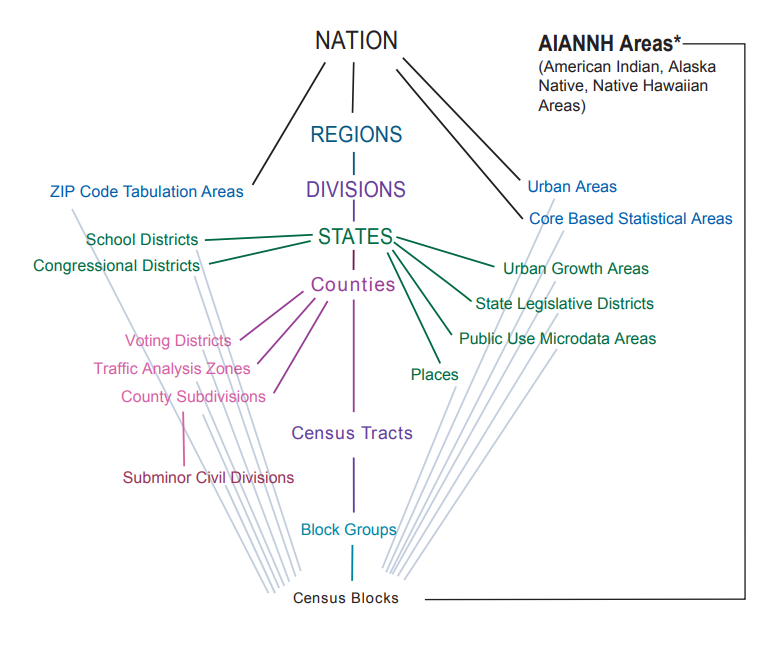

**The American Community Survey (ACS)** is a survey conducted by the U.S. Census Bureau to collect data on a wide range of topics, including demographic, economic, and social characteristics of the U.S. population. It is conducted every year, with additional estimates produced every 5 years (3-year summaries have been discontinued). The ACS is the largest household survey in the United States, and it covers the entire U.S. population, including both rural and urban areas. See https://www.census.gov/programs-surveys/acs/guidance/estimates.html

 
**TIGER**: Topologically Integrated Geographic Encoding and Referencing database. It is a high-quality series of geographic datasets released by the US Census Bureau.


### You can find variables via Census API directly (https://api.census.gov/data/2023/acs/acs5/profile/variables.html) or using a census wrapper (e.g., censusdata)

In [ ]:
# how to figure out which variables to retrive?
import censusdata

# this will find all variables where "income" is mentioned in the variable label
censusdata.search('acs5', 2019, 'label', 'income') 

# alternatively, search for concepts:
# censusdata.search('acs5', 2019, 'concept', 'income') 


### Retrieving spatial units: better to use a wrapper (cencusdis, cenpy, etc.)

Here, we will use pygris by Kyle Walker See https://walker-data.com/pygris/

In [ ]:
import pygris
ca_counties = pygris.counties(state = "CA")

In [ ]:
ca_counties.explore()

In [ ]:
sd_roads = pygris.roads(state = "CA", county = "San Diego")
sd_roads.plot()

In [ ]:
sd_tracts = pygris.tracts(state = "CA", county = "San Diego")
sd_tracts.plot()

The core TIGER/Line shapefiles include water area that belongs to US states and counties

Use the argument cb = True to obtain a cartographic boundary shapefile pre-clipped to the US shoreline



In [ ]:
import matplotlib.pyplot as plt

# Get the default TIGER/Line file for counties in Michigan
sd_tiger = pygris.tracts(state = "CA", county = "San Diego")
# Get the cartographic boundary file with cb = True
sd_cartographic = pygris.tracts(state = "CA", county = "San Diego", cb = True, cache = True)
# Plot the two side-by-side to compare them
fig, ax = plt.subplots(ncols = 2, figsize = (10, 8))
sd_tiger.plot(ax = ax[0])
sd_cartographic.plot(ax = ax[1])
ax[0].set_title("TIGER/Line")
ax[1].set_title("Cartographic")

### How to show the US along with Alaska and Hawaii and other US territories, in a compact way?

In [ ]:
us = pygris.states(cb = True, resolution = "20m")
us.plot(figsize = (12, 8))

In [ ]:
# instead, use shift_geometry

from pygris.utils import shift_geometry
us_rescaled = shift_geometry(us)
us_rescaled.plot(figsize = (12, 8))


In [ ]:
us_rescaled.explore()

In [ ]:
# Customize the display with position and preserve_area arguments

us_shifted = shift_geometry(us, position = "outside", preserve_area = True)
us_shifted.plot(figsize = (12, 8))

### Making Choropleth maps:

In [ ]:


ca_counties = ["San Diego", "Imperial", "Orange","San Bernardino","Riverside"]
ca_tracts = pygris.tracts(state = "CA", county = ca_counties, cb = True,
                    year = 2021, cache = True)

from pygris.data import get_census

# variable DP02_0068PE == Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher


ca_college = get_census(dataset = "acs/acs5/profile",
                        variables = "DP02_0068PE",
                        year = 2021,
                        params = {
                          "for": "tract:*",
                          "in": "state:06"},
                        guess_dtypes = True,
                        return_geoid = True)

ca_merged = ca_tracts.merge(ca_college, how = "inner", on = "GEOID")

ca_merged.plot(column = "DP02_0068PE", legend = True,
               figsize = (10, 10), cmap = "plasma", 
               legend_kwds = dict(shrink = 0.5),
               missing_kwds = dict(color = "lightgrey"))
plt.title("Percent with bachelor's degree or higher\nin 5 California counties, 2017-2021 ACS")
ax = plt.gca()
ax.set_axis_off()

### Geocoding with Pygris

In [ ]:
from pygris.geocode import geocode
geocode("300 Broadway, San Diego, CA")

In [ ]:
# or, create a GDF directly

geoc_df = geocode("300 Broadway, San Diego, CA", as_gdf = True)
geoc_df.explore(marker_type = "marker")

In [ ]:
# find census tracts near this address (within a distance of 5000):

from pygris import tracts
geoc_tracts = tracts(state = "CA", cb = True, 
                      subset_by = {"300 Broadway, San Diego, CA": 2000})
geoc_tracts.explore()

# OpenStreetMap

OpenStreetMap (OSM) is a free online spatial database and mapping and analysis software services (osm.org). It is updated by a community of volunteers. OSM data can be accessed via an API, and converted for use in other GIS systems. See https://en.wikipedia.org/wiki/OpenStreetMap


In [ ]:
import osmnx as ox
import pandas as pd
import geopandas as gpd 
import seaborn as sns

## Retrieve street data from OSM

In [ ]:
# specify a location, and get a street network graph for it 
place = "Del Mar, San Diego county, CA"
graph = ox.graph_from_place(place, network_type='drive')

In [ ]:
# The result is a Networkx class; can be converted to Geopandas:
nodes, streets = ox.graph_to_gdfs(graph)
streets.head()

In [ ]:
# visualize the streets with folium
import folium

style = {'color': '#F7DC6F', 'weight':'1'}
m = folium.Map([32.95, -117.265],
    zoom_start=13,
    tiles='CartoDb dark_matter')
folium.GeoJson(streets, style_function=lambda x: style).add_to(m)
m.save('streets.html')
m

## Retrieve building footprint from OSM

Note the tags: 

https://wiki.openstreetmap.org/wiki/Tags

https://taginfo.openstreetmap.org/


In [ ]:
from osmnx import features
buildings = features.features_from_place(place, tags={'building': True})
buildings.shape

In [ ]:
import xyzservices.providers as xyz

# map the buildings
style_buildings = {'color':'#6C3483 ', 'fillColor': '#6C3483 ', 'weight':'1', 'fillOpacity' : 1}


# Create map with proper attribution
m = folium.Map([32.95, -117.265],
               zoom_start=14,
               tiles="CartoDB positron")

folium.GeoJson(buildings[:1000], style_function=lambda x: style_buildings).add_to(m)
m.save("buildings.html")
m


## Retrieve point of interest locations from OSM

In [ ]:
place = "Del Mar, San Diego county, CA"

tags = {'amenity': 'restaurant'}
r = ox.features.features_from_place(place, tags=tags)
r.head()

In [ ]:
r.shape

In [ ]:
r_points = r[r.geom_type == 'Point'][:100]

In [ ]:
m = folium.Map([32.95, -117.265],
               zoom_start=14,
               tiles="CartoDB positron")
locs = zip(r_points.geometry.y, r_points.geometry.x)
folium.GeoJson(streets, style_function=lambda x: style).add_to(m)
folium.GeoJson(buildings[:1000], style_function=lambda x: style_buildings).add_to(m)
for location in locs:
    folium.CircleMarker(location=location).add_to(m)
    m.save('delmar_restaurants.html')
m

## Many OSM layers are already in ArcGIS Online

For example, point data for North America:

address points:  https://ucsdonline.maps.arcgis.com/home/item.html?id=3e55b3ba0a604240aa0e2dc1081822e0

educational establishments: https://ucsdonline.maps.arcgis.com/home/item.html?id=d069bac97644415a90fea85720047f18

In [ ]:
import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
import pandas as pd
gis=GIS("https://ucsdonline.maps.arcgis.com/home", client_id="bZshlNXFuaR2KHff") 


### See https://ucsdonline.maps.arcgis.com/home/content.html?sortField=relevance&sortOrder=desc&searchTerm=openstreetmap&view=table#living%20atlas for OpenStreetMap layers


In [ ]:
# You can reference local copies of OSM feature layers

address_points = gis.content.get("3e55b3ba0a604240aa0e2dc1081822e0")
educ_points = gis.content.get("d069bac97644415a90fea85720047f18")

In [ ]:
educ_points